# Imports

In [222]:
from pathlib import Path
from datetime import datetime
from typing import Callable, Optional, Sequence, Tuple
import torch
from torch import Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import uncertainty_toolbox as uct
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pytorch_lightning import LightningModule
from simple_uq.models.pnn import PNN

# Uploads

In [223]:
prefix = "./data/earth"
prefix_1A = "./data/flight/titer"
uploaded = {p.name: p for p in Path(prefix).glob("*.xlsx") if not p.name.startswith("~$")}
uploaded_1A = {p.name: p for p in Path(prefix_1A).glob("*.xlsx") if not p.name.startswith("~$")}

# Settings

In [224]:

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [225]:
plt.rcParams.update({
    'axes.labelsize': 14,
    'axes.labelweight': 'bold',
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'xtick.color': 'k',
    'ytick.color': 'k',
    'xtick.major.width': 1.5,
    'ytick.major.width': 1.5,
})
plt.rcParams['figure.figsize'] = (7, 5)
plt.rcParams['figure.dpi'] = 120

# Preprocessing

In [226]:
organism_list = []
substance_list = []
gravity_list = []
obj_list = []

class Preprocess:
  def __init__(self, file_name):
    self.file_name = file_name
    self.organism, self.substance, self.gravity = self.file_name.split(".")[0].split()[0].split("_")
    self.update_list(organism_list, self.organism)
    self.update_list(substance_list, self.substance)
    self.update_list(gravity_list, self.gravity)

  def update_list(self, item_list, item):
    #if item not in item_list:
    item_list.append(item)

In [227]:
for file_name in uploaded:
  obj = Preprocess(file_name)
  obj_list.append(obj)

In [228]:
organism_encode = LabelEncoder()
substance_encode = LabelEncoder()
gravity_encode = LabelEncoder()

organism_label = organism_encode.fit_transform(organism_list)
substance_label = substance_encode.fit_transform(substance_list)
gravity_label = gravity_encode.fit_transform(gravity_list)

In [229]:
data_list = []
class Data:
  def __init__(self,file_name, organism, substance, gravity, flight = False):
    self.file_name = file_name
    self.organism = organism
    self.substance = substance
    self.gravity = gravity
    self.flight = flight
    self.titer_time, self.titer_val = self.assign_data()
    self.titer_input_np = []
    self.titer_val_np = []

    if len(self.titer_time) != 0:
      self.titer_input_np = self.create_inputs(self.titer_time, self.titer_val)
    if len(self.titer_val) != 0:
      self.titer_val_np = self.titer_val.reshape(-1, 1)

  def assign_data(self):
    titer_time = []
    titer_val = []

    if substance_encode.inverse_transform([self.substance])[0] != "Wild":
      # titer_df = pd.read_excel(self.file_name, sheet_name = 1).iloc[1:]
      if self.flight:
        titer_df = pd.read_excel(f"{prefix_1A}/{self.file_name}", sheet_name = 1).iloc[1:]
      else:
        titer_df = pd.read_excel(f"{prefix}/{self.file_name}", sheet_name = 1).iloc[1:]
      titer_time = titer_df.iloc[:,:1].to_numpy()
      titer_df_transpose = titer_df.iloc[:,1:].T
      titer_df_transpose.fillna(titer_df_transpose.mean(), inplace=True)
      titer_val = titer_df_transpose.T.to_numpy()
    return titer_time, titer_val

  def create_inputs(self, input, output):
    """
    Returns inputs in order of organism, substance, gravity, and time
    """
    input_length = len(input)
    output_length = len(output[0])

    input_stacked = np.tile(input, output_length).reshape(-1, 1)

    categorical_inputs = [self.organism, self.substance, self.gravity]
    categorical_inputs_stacked = np.tile(categorical_inputs, input_length * output_length).reshape(-1, len(categorical_inputs))

    return np.hstack((categorical_inputs_stacked, input_stacked)).astype(float)

In [ ]:
for i, obj in enumerate(obj_list):
  data_obj = Data(obj.file_name, organism_label[i], substance_label[i], gravity_label[i])
  data_list.append(data_obj)

In [231]:
titer_input = data_list[0].titer_input_np
titer_output = data_list[0].titer_val_np

for i in range(1, len(data_list)):
  if len(data_list[i].titer_input_np) > 0:
    titer_input = np.vstack((titer_input, data_list[i].titer_input_np))
    titer_output = np.vstack((titer_output, data_list[i].titer_val_np))

In [232]:
titer_time_input_mean = np.mean(titer_input[:, 3])
titer_time_input_std_dev = np.std(titer_input[:, 3])
titer_input[:,3] = (titer_input[:, 3] - titer_time_input_mean)/titer_time_input_std_dev
titer_output = np.log(titer_output + 0.1)

In [233]:
#80% train, 10% validation, 10% test
titer_input_train, titer_input_test_val, titer_output_train, titer_output_test_val = train_test_split(titer_input, titer_output, test_size = 0.2, random_state = 42)
titer_input_val, titer_input_test, titer_output_val, titer_output_test = train_test_split(titer_input_test_val, titer_output_test_val, test_size = 0.5, random_state = 42)

In [234]:
titer_input_train_tensor = torch.tensor(titer_input_train, device=device)
titer_input_test_tensor = torch.tensor(titer_input_test,device=device)
titer_output_train_tensor = torch.tensor(titer_output_train,device=device)
titer_output_test_tensor = torch.tensor(titer_output_test,device=device)
titer_input_val_tensor = torch.tensor(titer_input_val, device=device)
titer_output_val_tensor = torch.tensor(titer_output_val, device=device)

In [235]:
train_data = DataLoader(TensorDataset(torch.tensor(titer_input_train, dtype = torch.float32), torch.tensor(titer_output_train, dtype = torch.float32)))
test_data = DataLoader(TensorDataset(torch.tensor(titer_input_test, dtype = torch.float32), torch.tensor(titer_output_test, dtype = torch.float32)))
val_data = DataLoader(TensorDataset(torch.tensor(titer_input_val, dtype = torch.float32), torch.tensor(titer_output_val, dtype = torch.float32)))

# Model

In [236]:
"""Make the PNN model."""
pnn = PNN(
    input_dim=4,
    output_dim=1,
    encoder_hidden_sizes=[50, 50, 50, 50, 50],
    encoder_output_dim=50,
    mean_hidden_sizes=[],
    logvar_hidden_sizes=[],
    hidden_activation = F.relu,
    learning_rate = 1e-3,
)

In [237]:
model_path = './models/titer'

if not model_path:
  """Train the model with a pytorch-lightning trainer."""
  trainer = pl.Trainer(max_epochs=100, check_val_every_n_epoch=50)
  trainer.fit(pnn, train_data, val_data)
  # Get the test output.
  test_results = trainer.test(pnn, test_data)
  #model_path = '/content/drive'
  timestamp = datetime.now()
  time_path = f"_{timestamp.strftime('%m-%d_%H-%M-%S')}.pth"
  torch.save(pnn.state_dict(), model_path + time_path)
else:
  #load the model
  time_path = ".pth"
  pnn.load_state_dict(torch.load(model_path + time_path))

# Flight

In [238]:
organism_1A_list = []
substance_1A_list = []
gravity_1A_list = []
obj_1A_list = []

In [239]:
class Preprocess_flight:
  def __init__(self, file_name):
    self.file_name = file_name
    self.organism, self.substance, self.gravity, self.flight = self.file_name.split(".")[0].split()[0].split("_")
    self.update_list(organism_1A_list, self.organism)
    self.update_list(substance_1A_list, self.substance)
    self.update_list(gravity_1A_list, self.gravity)

  def update_list(self, item_list, item):
    #if item not in item_list:
    item_list.append(item)

In [240]:
for file_name in uploaded_1A.keys():
  obj = Preprocess_flight(file_name)
  obj_1A_list.append(obj)

In [241]:
def locate_label(var, var_list, var_encode_list):
  index = var_list.index(var)
  return var_encode_list[index]

C:\Users\ipjos\AppData\Local\Temp\ipykernel_37200\2482386220.py:30: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  titer_df_transpose.fillna(titer_df_transpose.mean(), inplace=True)


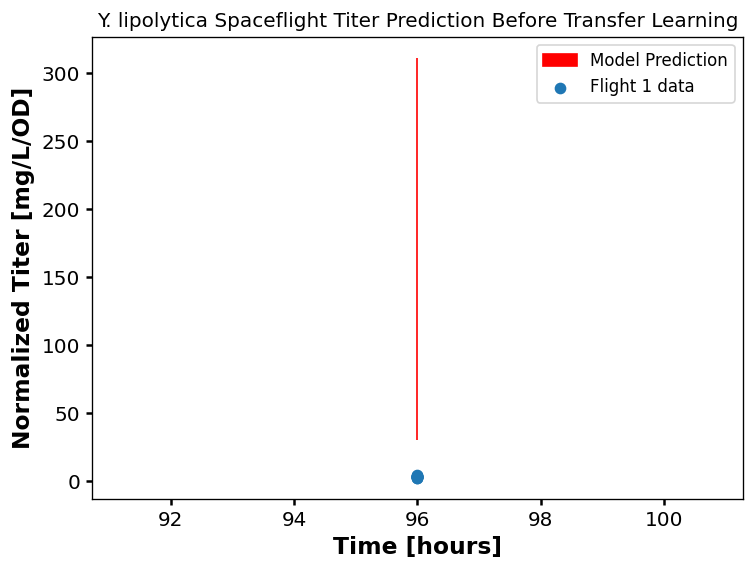

In [243]:
data_1A_list = []

for i, obj in enumerate(obj_1A_list):
  organism_locate_label = locate_label(obj.organism, organism_list, organism_label)
  substance_locate_label = locate_label(obj.substance, substance_list, substance_label)
  gravity_locate_label = locate_label(obj.gravity, gravity_list, gravity_label)

  #use the combination of labels to locate the correct obj_list item
  # print(obj.file_name)
  # print(organism_locate_label, substance_locate_label, gravity_locate_label)
  data_obj = Data(obj.file_name, organism_locate_label, substance_locate_label, gravity_locate_label, flight = True)
  data_1A_list.append(data_obj)

  #combine into categorical inputs
  categorical_inputs = [organism_locate_label, substance_locate_label, gravity_locate_label]
  categorical_inputs_transformed = torch.tensor([categorical_inputs]).squeeze()

  #replace time_linspace_tensor, define this as the list of time elements
  time_tensor = torch.tensor(data_obj.titer_input_np[:,3], dtype = torch.float32)
  categorical_inputs_transformed_stacked = torch.Tensor.repeat(categorical_inputs_transformed, len(time_tensor)).reshape(-1, len(categorical_inputs))

  input_unstandardized = torch.hstack((categorical_inputs_transformed_stacked, time_tensor.reshape(-1, 1)))
  input_unstandardized[:,3] = (input_unstandardized[:,3] - titer_time_input_mean) / titer_time_input_std_dev

  input_standardized = input_unstandardized
  predicted_output_mean, predicted_output_std = pnn.get_mean_and_standard_deviation(input_standardized.numpy())

  time_tensor = time_tensor.numpy().flatten()
  predicted_output_mean = predicted_output_mean.flatten()
  predicted_output_std = predicted_output_std.flatten()

  # plt.title(f"{organism_encode.inverse_transform([data_obj.organism])[0]} {substance_encode.inverse_transform([data_obj.substance])[0]} {gravity_encode.inverse_transform([data_obj.gravity])[0]} Titer with 95% Confidence Interval")
  plt.title("Y. lipolytica Spaceflight Titer Prediction Before Transfer Learning")
  mean = np.exp(predicted_output_mean) - 0.1
  diff = np.exp(predicted_output_mean + 3 * predicted_output_std) - np.exp(predicted_output_mean)

  plt.fill_between(time_tensor,
                   # predicted_output_mean - 3 * predicted_output_std,
                   # predicted_output_mean + 3 * predicted_output_std,
                   # np.exp(predicted_output_mean) - 0.1,
                   # np.exp(predicted_output_mean - 3 * predicted_output_std) - np.exp(predicted_output_mean),
                   # np.exp(predicted_output_mean + 3 * predicted_output_std) - np.exp(predicted_output_mean),
                   mean - diff,
                   mean + diff,
                   #alpha = 0.2,
                   color = 'red',
                   # label=f"{gravity_encode.inverse_transform([data_1A_list[i].gravity])[0]} Prediction"
                   label = "Model Prediction",
                   )

  # plt.errorbar(time_tensor,
  #              np.exp(predicted_output_mean) - 0.1,
  #              np.exp(predicted_output_mean + 3 * predicted_output_std) - np.exp(predicted_output_mean),
  #              marker = 'o',
  #              color = 'red',
  #              label = f"{gravity_encode.inverse_transform([data_1A_list[i].gravity])[0]} Prediction",)

  plt.scatter(time_tensor,
              data_obj.titer_val_np,
              label = "Flight 1 data")
  plt.xlabel("Time [hours]")
  plt.ylabel("Normalized Titer [mg/L/OD]")
  plt.legend()
  plt.show()